In [25]:
import pandas as pd 
import os 
import matplotlib.pyplot as plt 
import numpy as np 
import seaborn as sns

sns.set(style='ticks') # makes longer tick marks
sns.set_context('poster') # makes text larger

In [26]:
# * Windows versus mac.
#folder = '/Volumes/Aleman-Lab/Group/Projects/GrapheneCoupledResonators/Data/Sample2/2019/08/09/'
folder = r'\\cas-fs1.uoregon.edu\Material-Science-Institute\Aleman-Lab\Group\Projects\GrapheneCoupledResonators\Data\Sample2\2019\08\09' 
file = 'PumpGU01Array01.00r0.5p3Array01.00r0.5p3Device1.2DrumGate113721' 
path = os.path.join(folder,file)
df = pd.read_csv(os.path.join(path, 'Demod1.csv'), skiprows = 2) 
#df.r = df.r/df.r.max() 
#print(df)  

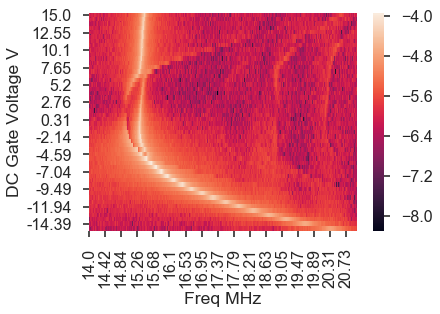

In [27]:
df['rlog'] = np.log10(df.r) 
df['Freq MHz']=(df.frequency)/10**6
df['Freq MHz']= df['Freq MHz'].round(2)
df['DC Gate Voltage V'] = df['Keithley Voltage'].round(2)
p = df.pivot_table(index = 'DC Gate Voltage V', columns = 'Freq MHz', values = 'rlog').sort_index(axis = 0, ascending = False) 
sns.heatmap(p)

C:\Users\vhorowit\AppData\Local\conda\conda\envs\py36\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
C:\Users\vhorowit\AppData\Local\conda\conda\envs\py36\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
C:\Users\vhorowit\AppData\Local\conda\conda\envs\py36\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """


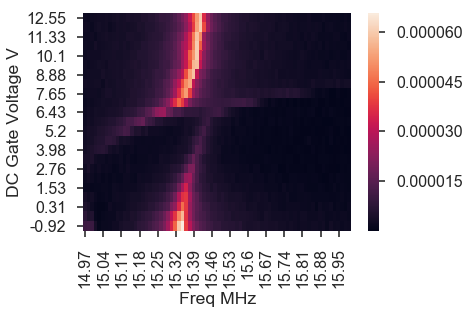

In [28]:
lf = df['Freq MHz'] > 14.95 
hf = df['Freq MHz'] < 16 
lv = df['DC Gate Voltage V'] > -1
hv = df['DC Gate Voltage V'] < 13.1
n = df[lf][hf][lv][hv].pivot_table(index = 'DC Gate Voltage V', columns = 'Freq MHz', values = 'r').sort_index(axis = 0, ascending = False)
sns.heatmap(n)

In [29]:
#path = '/Volumes/Aleman-Lab/Group/Projects/GrapheneCoupledResonators/Data/Sample2/2019/08/09/PumpGU01Array01.00r0.5p3Array01.00r0.5p3Device1.2RandomNodeGate115601' 
path = os.path.join(folder,'PumpGU01Array01.00r0.5p3Array01.00r0.5p3Device1.2RandomNodeGate115601')
df = pd.read_csv(os.path.join(path, 'Demod1.csv'), skiprows = 2) 
#df.r = df.r/df.r.max() 
#print(df)

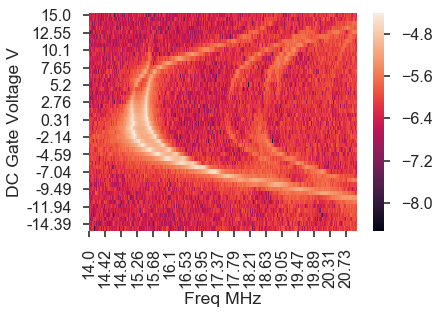

In [30]:
df['rlog'] = np.log10(df.r) 
df['Freq MHz']=(df.frequency)/10**6
df['Freq MHz']= df['Freq MHz'].round(2)
df['DC Gate Voltage V'] = df['Keithley Voltage'].round(2)
p = df.pivot_table(index = 'DC Gate Voltage V', columns = 'Freq MHz', values = 'rlog').sort_index(axis = 0, ascending = False) 
sns.heatmap(p)

C:\Users\vhorowit\AppData\Local\conda\conda\envs\py36\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
C:\Users\vhorowit\AppData\Local\conda\conda\envs\py36\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
C:\Users\vhorowit\AppData\Local\conda\conda\envs\py36\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """


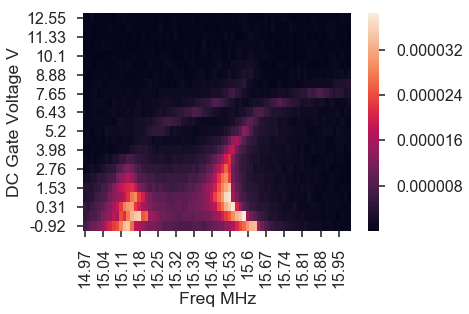

In [31]:
lf = df['Freq MHz'] > 14.95 
hf = df['Freq MHz'] < 16 
lv = df['DC Gate Voltage V'] > -1
hv = df['DC Gate Voltage V'] < 13.1
n = df[lf][hf][lv][hv].pivot_table(index = 'DC Gate Voltage V', columns = 'Freq MHz', values = 'r').sort_index(axis = 0, ascending = False)
sns.heatmap(n)

In [20]:
path = os.path.join(folder,'PumpGU01Array01.00r0.5p3Array01.00r0.5p3Device1.2RandomNode110245')
df = pd.read_csv(os.path.join(path, 'Demod1.csv'), skiprows = 2) 
#df.r = df.r/df.r.max() 
#print(df)

In [21]:
df['rlog'] = np.log10(df.r) 
df['Freq MHz']=(df.frequency)/10**6
df['Freq MHz']= df['Freq MHz'].round(2)
df['Blue Laser Power'] = df['DC Offset'].round(2)
p = df.pivot_table(index = 'Blue Laser Power', columns = 'Freq MHz', values = 'r').sort_index(axis = 0, ascending = False) 
p.columns_heatmap.set_xticklabels(g.ax_heatmap.get_xmajorticklabels(), fontsize = 16)
sns.heatmap(p, yticklabels=False)

AttributeError: 'DataFrame' object has no attribute 'columns_heatmap'

In [22]:
path = os.path.join(folder,'PumpGU01Array01.00r0.5p3Array01.00r0.5p3Device1.2Drum1094547')
df = pd.read_csv(os.path.join(path, 'Demod1.csv'), skiprows = 2) 
#df.r = df.r/df.r.max() 
#print(df)

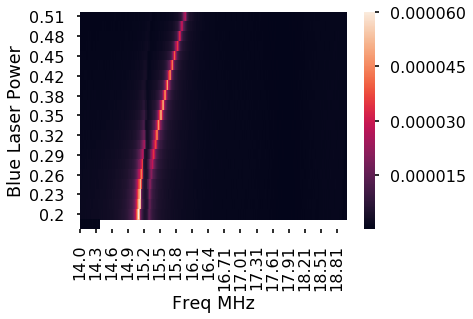

In [23]:
df['rlog'] = np.log10(df.r) 
df['Freq MHz']=(df.frequency)/10**6
df['Freq MHz']= df['Freq MHz'].round(2)
df['Blue Laser Power'] = df['DC Offset'].round(2)
p = df.pivot_table(index = 'Blue Laser Power', columns = 'Freq MHz', values = 'r').sort_index(axis = 0, ascending = False) 
sns.heatmap(p)

C:\Users\vhorowit\AppData\Local\conda\conda\envs\py36\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
C:\Users\vhorowit\AppData\Local\conda\conda\envs\py36\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
C:\Users\vhorowit\AppData\Local\conda\conda\envs\py36\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """


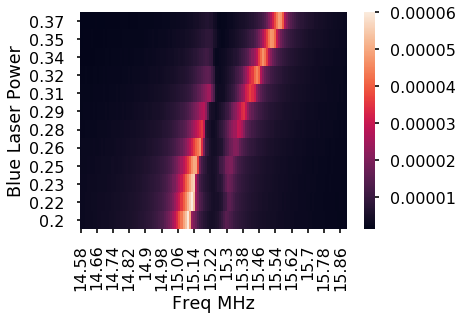

In [24]:
lf = df['Freq MHz'] > 14.57 
hf = df['Freq MHz'] < 15.9 
lv = df['Blue Laser Power'] > 0.1
hv = df['Blue Laser Power'] < 0.38
n = df[lf][hf][lv][hv].pivot_table(index = 'Blue Laser Power', columns = 'Freq MHz', values = 'r').sort_index(axis = 0, ascending = False)
sns.heatmap(n)